# Gene Expression Prediction from DNA Sequences

This notebook provides a comprehensive analysis for predicting gene expression levels from DNA sequences using various machine learning approaches.

## Table of Contents
1. [Data Loading and Exploration](#data-loading)
2. [Data Preprocessing](#data-preprocessing)
3. [Feature Engineering](#feature-engineering)
4. [Model Training and Evaluation](#model-training)
5. [Results and Visualization](#results)
6. [Conclusions](#conclusions)


## 1. Data Loading and Exploration


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)


In [ ]:
# Load data
import sys
from pathlib import Path

# Get the project root directory (parent of notebooks directory)
base_path = Path().resolve().parent
data_path = base_path / 'data' / 'genomics_data.csv'

df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (2000, 2)


,Sequences,Labels
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [4]:
# Explore the data
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("Label Distribution:")
print(df['Labels'].value_counts())
print("\n" + "="*50)
print("Label Proportions:")
print(df['Labels'].value_counts(normalize=True))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sequences  2000 non-null   object
 1   Labels     2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None

Label Distribution:
Labels
0    1013
1     987
Name: count, dtype: int64

Label Proportions:
Labels
0    0.5065
1    0.4935
Name: proportion, dtype: float64


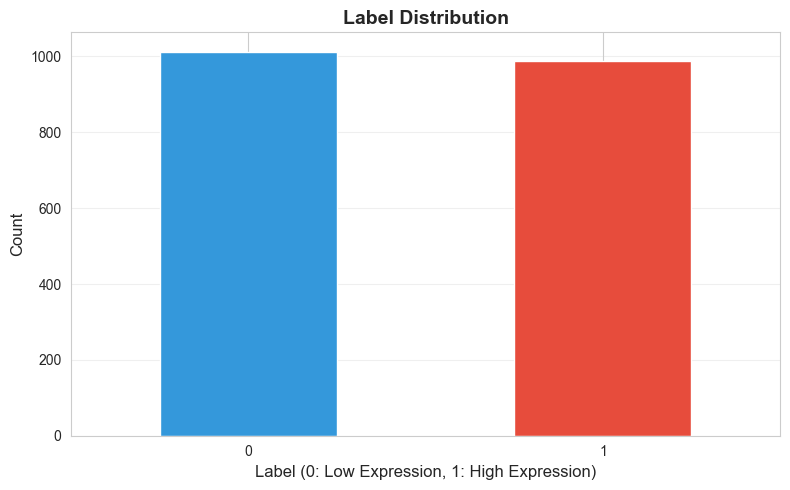

In [5]:
# Visualize label distribution
plt.figure(figsize=(8, 5))
df['Labels'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Label Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Label (0: Low Expression, 1: High Expression)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 2. Feature Engineering


In [6]:
def kmer_encoding(sequences, k=3):
    """Convert DNA sequences to k-mer frequency features."""
    kmers = []
    for seq in sequences:
        seq_kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmers.append(' '.join(seq_kmers))
    
    vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\S+')
    X = vectorizer.fit_transform(kmers).toarray()
    
    return X, vectorizer

# Encode sequences using k-mers (trinucleotides)
sequences = df['Sequences'].tolist()
labels = df['Labels'].values

print("Encoding sequences using k-mer approach (k=3)...")
X, vectorizer = kmer_encoding(sequences, k=3)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of unique k-mers: {X.shape[1]}")


Encoding sequences using k-mer approach (k=3)...
Feature matrix shape: (2000, 64)
Number of unique k-mers: 64


## 3. Model Training and Evaluation


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Test label distribution: {np.bincount(y_test)}")


Training set: 1600 samples
Test set: 400 samples
Training label distribution: [810 790]
Test label distribution: [203 197]


In [8]:
# Initialize and train models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'SVM': SVC(probability=True, random_state=42, kernel='rbf')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")



Training Random Forest...
  Accuracy: 1.0000
  ROC-AUC: 1.0000

Training Gradient Boosting...
  Accuracy: 0.9950
  ROC-AUC: 1.0000

Training XGBoost...
  Accuracy: 0.9950
  ROC-AUC: 1.0000

Training LightGBM...
  Accuracy: 0.9975
  ROC-AUC: 1.0000

Training SVM...
  Accuracy: 0.9775
  ROC-AUC: 0.9948


## 4. Results and Visualization


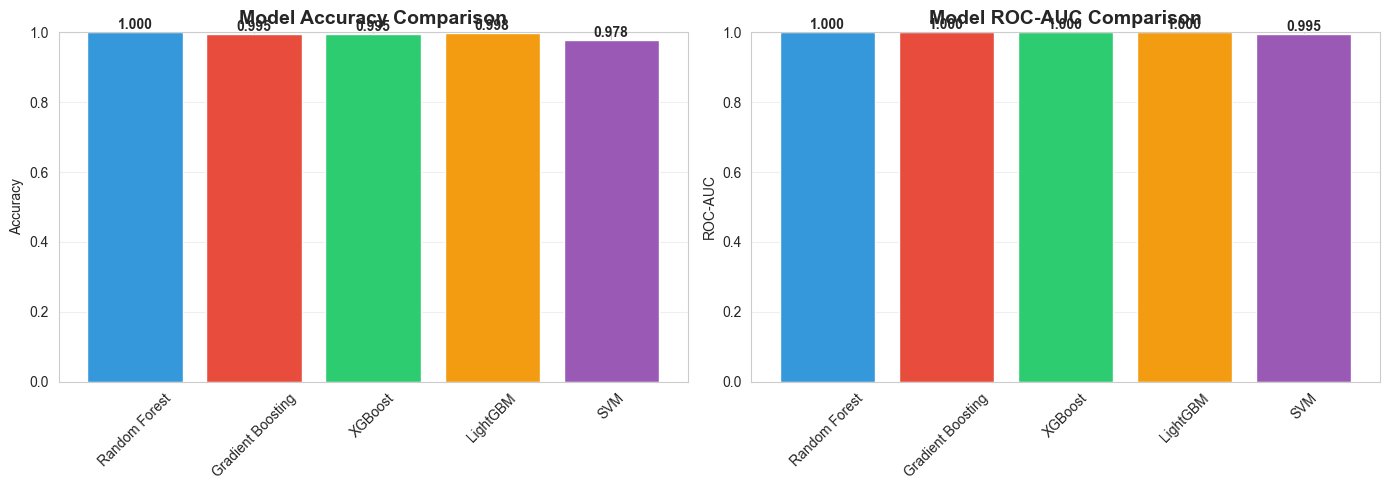

In [9]:
# Compare model performance
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
roc_aucs = [results[m]['roc_auc'] for m in model_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(model_names, accuracies, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
for i, (name, acc) in enumerate(zip(model_names, accuracies)):
    axes[0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold')

# ROC-AUC comparison
axes[1].bar(model_names, roc_aucs, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
axes[1].set_title('Model ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
for i, (name, auc) in enumerate(zip(model_names, roc_aucs)):
    axes[1].text(i, auc + 0.01, f'{auc:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


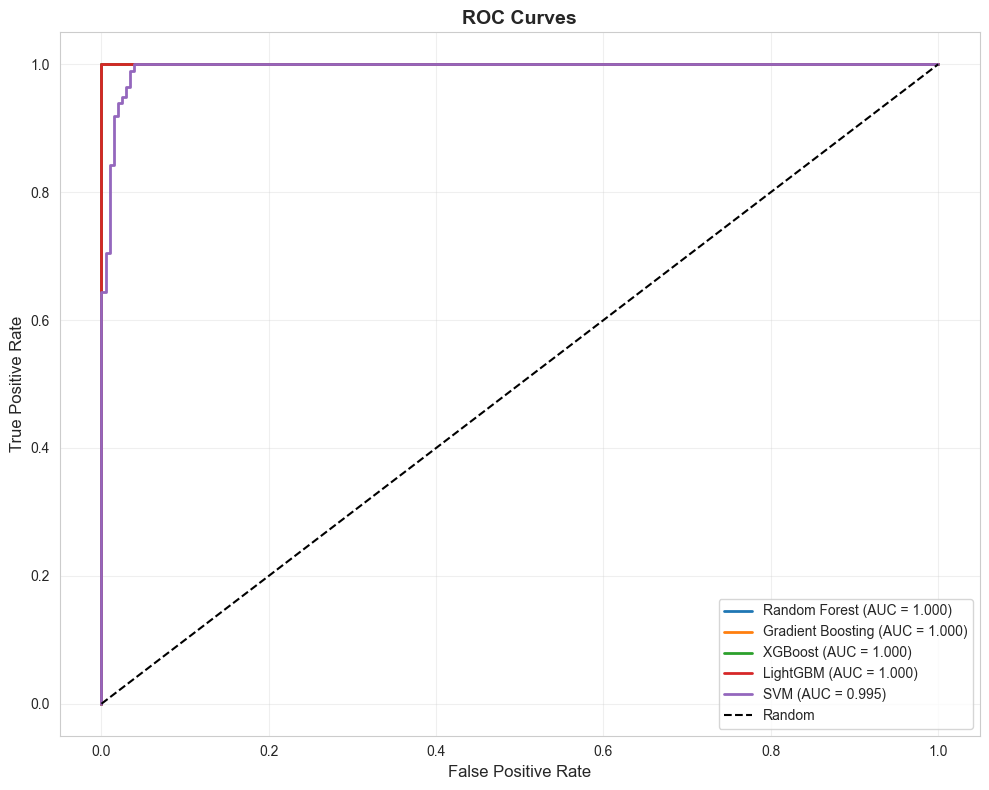

In [10]:
# ROC curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# Print detailed classification reports
for name, result in results.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(result['classification_report'])
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"ROC-AUC: {result['roc_auc']:.4f}")



Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00       197

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Accuracy: 1.0000
ROC-AUC: 1.0000

Gradient Boosting
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       203
           1       0.99      1.00      0.99       197

    accuracy                           0.99       400
   macro avg       0.99      1.00      0.99       400
weighted avg       1.00      0.99      1.00       400

Accuracy: 0.9950
ROC-AUC: 1.0000

XGBoost
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       203
           1       0.99      1.00      0.99       197

    accuracy                           0.99       400
   macro avg       